#### Import libraries and packages

In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')

#### Import dataset

In [2]:
df = pd.read_csv("C:\\Users\\DNV\\OneDrive\\Desktop\\Data-Gold.csv",parse_dates=True,index_col=0)

#### Create a new Timestamp column for time series forecasting

In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['VND'].values.reshape(-1, 1)
df.head()

,VND,Timestamp
Date,,
2012-01-02,32202288.50,1.325462e+09
2012-01-03,33607538.00,1.325549e+09
2012-01-04,33923003.00,1.325635e+09
2012-01-05,33628569.00,1.325722e+09
2012-01-06,34000652.75,1.325808e+09


#### Plotting Gold price chart

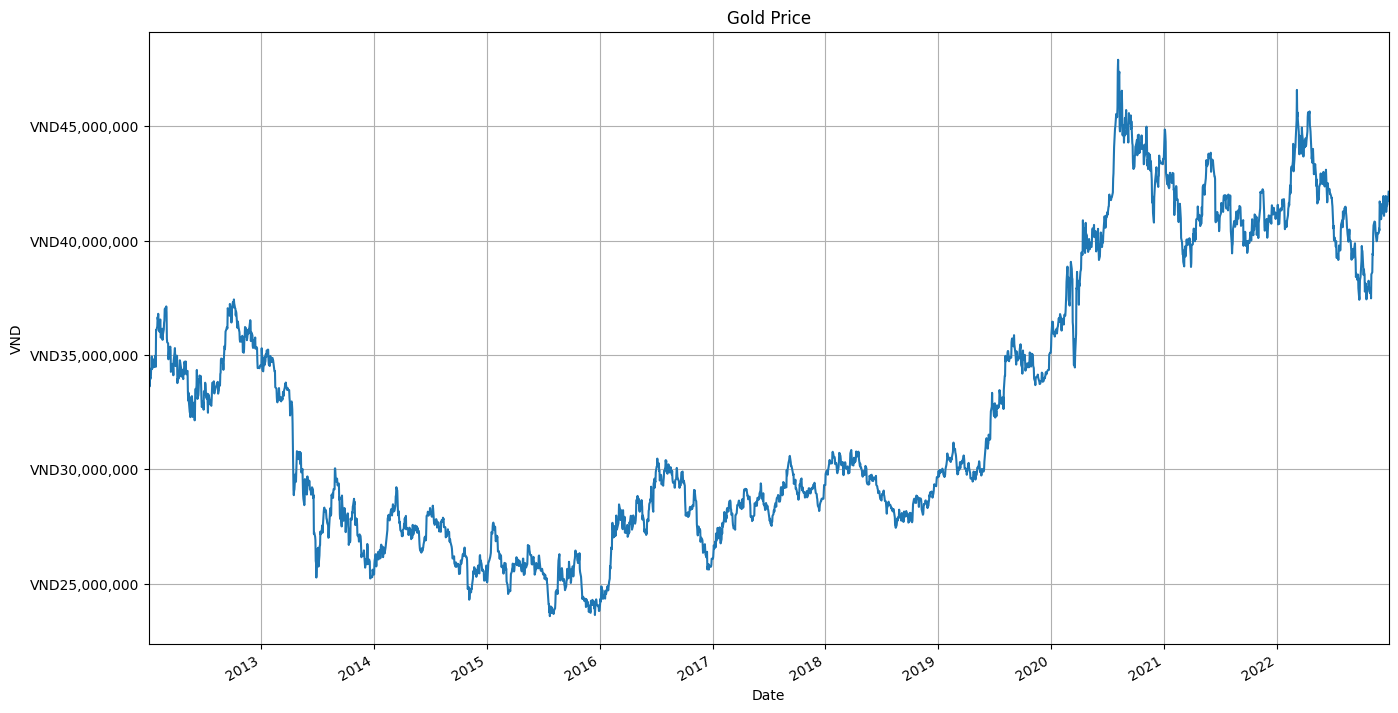

In [4]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('VND{x:,.0f}')

title = 'Gold Price'
ylabel = 'VND'
xlabel = 'Date'

ax = df['VND'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

#### Normalizing / scaling data to facilitate model building

In [5]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['VND'] = LR_sc.fit_transform(df_open)
df_scaled

,VND,Timestamp
Date,,
2012-01-02,-0.062575,1.325462e+09
2012-01-03,0.167826,1.325549e+09
2012-01-04,0.219549,1.325635e+09
2012-01-05,0.171274,1.325722e+09
2012-01-06,0.232280,1.325808e+09
...,...,...
2022-12-26,1.476100,1.672013e+09
2022-12-27,1.526588,1.672099e+09
2022-12-28,1.499084,1.672186e+09


In [6]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['VND'] = y_scaled
df_scaled.head()

,Timestamp,VND
Date,,
2012-01-02,-1.730686,-0.062575
2012-01-03,-1.729824,0.167826
2012-01-04,-1.728962,0.219549
2012-01-05,-1.728100,0.171274
2012-01-06,-1.727237,0.232280


#### Split data for training and testing ( 9-1 )

In [7]:
interrupt = int(len(df_scaled) * .9)

train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)

(2583, 2)
(287, 2)


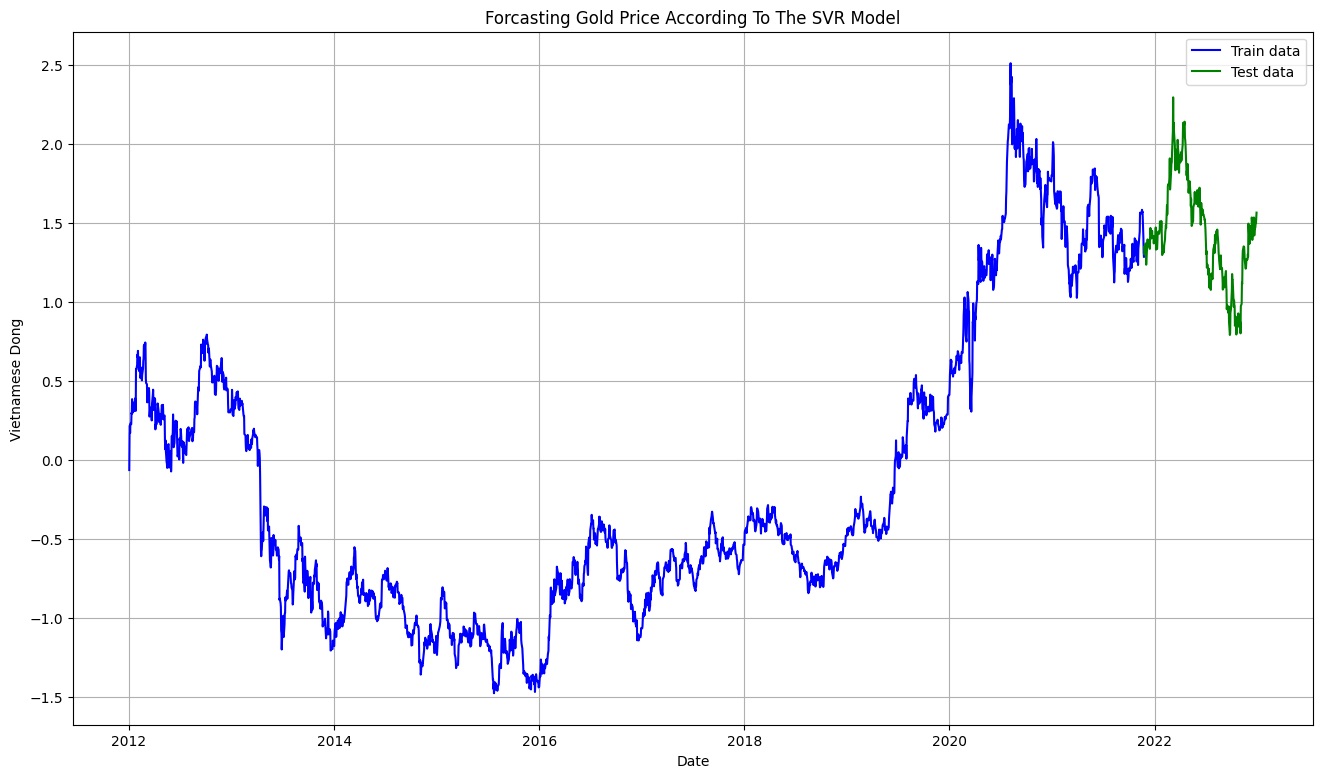

In [8]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Vietnamese Dong')
plt.xlabel('Date')
plt.title("Forcasting Gold Price According To The SVR Model")
plt.plot(train_data['VND'], 'blue', label='Train data')
plt.plot(test_data['VND'], 'green', label='Test data')
plt.legend()

#### Determine the independent variable (X) and the dependent variable (y).

In [9]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['VND'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['VND'].values.reshape(-1, 1)

#### The function that creates Hyperparameters 

In [10]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


#### The function that outputs the results of each case in GridSearch

In [11]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


#### Generate values for the hyperparameters

In [12]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


#### GridSearch to find suitable hyperparameters

In [13]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# GridSearch to find suitable hyperparameters
for ker in kernels:
    # If that is = = poly, make a choice degree.
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Transform back to original form
                inv_pred = y_sc.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Model Evaluation
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, degree=deg, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Transform back to original form
                    inv_pred = y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Model Evaluation
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=8470789.64 | MAPE=0.20 | MSE=75840550098042.73 | RMSE=8708648.01
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=7117839.14 | MAPE=0.17 | MSE=54977948970583.08 | RMSE=7414711.66
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=6149103.27 | MAPE=0.15 | MSE=42398809181806.04 | RMSE=6511436.80
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=5205155.80 | MAPE=0.12 | MSE=31991275659638.25 | RMSE=5656083.07
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=4277212.50 | MAPE=0.10 | MSE=23402750715542.53 | RMSE=4837638.96
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=3450211.85 | MAPE=0.08 | MSE=16370569707789.33 | RMSE=4046056.07
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=2850791.40 | MAPE=0.07 | MSE=11792421055647.99 | RMSE=3434009.47
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=2428974.60 | MAPE=0.06 | MSE=8798184527910.04 | RMSE=2966173.38
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=2218939.58 | MAPE=0.05 | MSE=7291800818769.19 | RMSE=2700333.46
SVR(kern

SVR(kernel=sigmoid, C=0.11, gamma=2.3000000000000003
MAE=153530163.52 | MAPE=3.73 | MSE=23731213804137468.00 | RMSE=154049387.55
SVR(kernel=sigmoid, C=0.11, gamma=2.4000000000000004
MAE=151441576.78 | MAPE=3.68 | MSE=23082620267358996.00 | RMSE=151929655.65
SVR(kernel=sigmoid, C=0.11, gamma=2.5000000000000004
MAE=149353592.76 | MAPE=3.63 | MSE=22443824257977648.00 | RMSE=149812630.50
SVR(kernel=sigmoid, C=0.11, gamma=2.6
MAE=147166932.08 | MAPE=3.57 | MSE=21785694886853632.00 | RMSE=147599779.43
SVR(kernel=sigmoid, C=0.11, gamma=2.7
MAE=145306620.92 | MAPE=3.53 | MSE=21232786089077940.00 | RMSE=145714742.18
SVR(kernel=sigmoid, C=0.11, gamma=2.8000000000000003
MAE=143560774.55 | MAPE=3.49 | MSE=20720331645435888.00 | RMSE=143945585.71
SVR(kernel=sigmoid, C=0.11, gamma=2.9000000000000004
MAE=142288838.00 | MAPE=3.46 | MSE=20349340988435400.00 | RMSE=142651116.32
SVR(kernel=sigmoid, C=0.11, gamma=3.0000000000000004
MAE=140586640.65 | MAPE=3.41 | MSE=19861118757043424.00 | RMSE=140929481.5

SVR(kernel=rbf, C=0.01, gamma=4.7
MAE=4577636.29 | MAPE=0.11 | MSE=24116096992061.11 | RMSE=4910814.29
SVR(kernel=rbf, C=0.01, gamma=4.8
MAE=4620939.63 | MAPE=0.11 | MSE=24523079429560.23 | RMSE=4952078.29
SVR(kernel=rbf, C=0.01, gamma=4.9
MAE=4649329.56 | MAPE=0.11 | MSE=24793250333935.47 | RMSE=4979282.11
SVR(kernel=rbf, C=0.11, gamma=0.1
MAE=3904512.93 | MAPE=0.10 | MSE=21766575756410.67 | RMSE=4665466.30
SVR(kernel=rbf, C=0.11, gamma=0.2
MAE=3170606.06 | MAPE=0.08 | MSE=14372430129783.33 | RMSE=3791098.80
SVR(kernel=rbf, C=0.11, gamma=0.30000000000000004
MAE=2965533.63 | MAPE=0.07 | MSE=12570029083986.86 | RMSE=3545423.68
SVR(kernel=rbf, C=0.11, gamma=0.4
MAE=3068527.07 | MAPE=0.08 | MSE=13311341599504.12 | RMSE=3648471.13
SVR(kernel=rbf, C=0.11, gamma=0.5
MAE=2868689.97 | MAPE=0.07 | MSE=11543894684173.32 | RMSE=3397630.75
SVR(kernel=rbf, C=0.11, gamma=0.6
MAE=2491552.83 | MAPE=0.06 | MSE=8660509321416.84 | RMSE=2942874.33
SVR(kernel=rbf, C=0.11, gamma=0.7000000000000001
MAE=19582

SVR(kernel=poly, C=0.01, gamma=0.5, degree=4
MAE=7169396.41 | MAPE=0.17 | MSE=59332408590156.60 | RMSE=7702753.31
SVR(kernel=poly, C=0.01, gamma=0.5, degree=5
MAE=15600853.39 | MAPE=0.38 | MSE=246190070272218.16 | RMSE=15690445.19
SVR(kernel=poly, C=0.01, gamma=0.6, degree=1
MAE=6154576.19 | MAPE=0.15 | MSE=42233978171050.20 | RMSE=6498767.43
SVR(kernel=poly, C=0.01, gamma=0.6, degree=2
MAE=6890941.04 | MAPE=0.16 | MSE=53099906012122.27 | RMSE=7286968.23
SVR(kernel=poly, C=0.01, gamma=0.6, degree=3
MAE=11670246.84 | MAPE=0.28 | MSE=139926480696616.75 | RMSE=11829052.40
SVR(kernel=poly, C=0.01, gamma=0.6, degree=4
MAE=7012833.08 | MAPE=0.17 | MSE=57324682199859.41 | RMSE=7571306.51
SVR(kernel=poly, C=0.01, gamma=0.6, degree=5
MAE=15705878.46 | MAPE=0.38 | MSE=249488287124058.03 | RMSE=15795198.23
SVR(kernel=poly, C=0.01, gamma=0.7000000000000001, degree=1
MAE=6056791.10 | MAPE=0.14 | MSE=41053036843198.66 | RMSE=6407264.38
SVR(kernel=poly, C=0.01, gamma=0.7000000000000001, degree=2
MAE=

SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=2
MAE=6590596.45 | MAPE=0.16 | MSE=49211421820749.90 | RMSE=7015085.30
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=3
MAE=11647736.03 | MAPE=0.28 | MSE=139407897919053.02 | RMSE=11807112.18
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=4
MAE=6886456.71 | MAPE=0.16 | MSE=55763977450580.95 | RMSE=7467528.20
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=5
MAE=15782967.36 | MAPE=0.38 | MSE=251924922353692.94 | RMSE=15872142.97
SVR(kernel=poly, C=0.01, gamma=2.0, degree=1
MAE=5347881.85 | MAPE=0.13 | MSE=33055127990797.11 | RMSE=5749358.92
SVR(kernel=poly, C=0.01, gamma=2.0, degree=2
MAE=6554961.96 | MAPE=0.16 | MSE=48759889599861.80 | RMSE=6982828.19
SVR(kernel=poly, C=0.01, gamma=2.0, degree=3
MAE=11641884.57 | MAPE=0.28 | MSE=139273611811214.11 | RMSE=11801424.14
SVR(kernel=poly, C=0.01, gamma=2.0, degree=4
MAE=6886473.65 | MAPE=0.16 | MSE=55764190560183.12 | RMSE=7467542.47
SVR(kernel=poly, C=

SVR(kernel=poly, C=0.01, gamma=3.2, degree=4
MAE=6884538.17 | MAPE=0.16 | MSE=55737624690081.90 | RMSE=7465763.50
SVR(kernel=poly, C=0.01, gamma=3.2, degree=5
MAE=15783400.42 | MAPE=0.38 | MSE=251938651137972.62 | RMSE=15872575.44
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=1
MAE=5240859.84 | MAPE=0.12 | MSE=31934722558035.13 | RMSE=5651081.54
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=2
MAE=6550533.83 | MAPE=0.16 | MSE=48704173134441.38 | RMSE=6978837.52
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=3
MAE=11641905.39 | MAPE=0.28 | MSE=139274090297831.86 | RMSE=11801444.42
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=4
MAE=6886404.87 | MAPE=0.16 | MSE=55763325284940.29 | RMSE=7467484.54
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=5
MAE=15782183.65 | MAPE=0.38 | MSE=251900077709511.12 | RMSE=15871360.30
SVR(kernel=poly, C=0.01, gamma=3.4000000000000004, degree=1
MAE=5223111.24 | MAPE=0.12 | MSE=31751128583529.48 | RMSE=

SVR(kernel=poly, C=0.01, gamma=4.6, degree=2
MAE=6540955.67 | MAPE=0.16 | MSE=48583837362550.56 | RMSE=6970210.71
SVR(kernel=poly, C=0.01, gamma=4.6, degree=3
MAE=11641848.63 | MAPE=0.28 | MSE=139272786611046.36 | RMSE=11801389.18
SVR(kernel=poly, C=0.01, gamma=4.6, degree=4
MAE=6885611.06 | MAPE=0.16 | MSE=55753339531264.42 | RMSE=7466815.89
SVR(kernel=poly, C=0.01, gamma=4.6, degree=5
MAE=15783697.50 | MAPE=0.38 | MSE=251948069472123.22 | RMSE=15872872.12
SVR(kernel=poly, C=0.01, gamma=4.7, degree=1
MAE=5194999.80 | MAPE=0.12 | MSE=31462541501657.00 | RMSE=5609148.02
SVR(kernel=poly, C=0.01, gamma=4.7, degree=2
MAE=6541021.80 | MAPE=0.16 | MSE=48584637158516.80 | RMSE=6970268.08
SVR(kernel=poly, C=0.01, gamma=4.7, degree=3
MAE=11643457.31 | MAPE=0.28 | MSE=139310230582690.00 | RMSE=11802975.50
SVR(kernel=poly, C=0.01, gamma=4.7, degree=4
MAE=6886109.79 | MAPE=0.16 | MSE=55759613210029.91 | RMSE=7467235.98
SVR(kernel=poly, C=0.01, gamma=4.7, degree=5
MAE=15790639.54 | MAPE=0.38 | MSE=

SVR(kernel=poly, C=0.11, gamma=1.1, degree=2
MAE=6550097.92 | MAPE=0.16 | MSE=48699476465992.59 | RMSE=6978501.02
SVR(kernel=poly, C=0.11, gamma=1.1, degree=3
MAE=11641898.32 | MAPE=0.28 | MSE=139273927805261.91 | RMSE=11801437.53
SVR(kernel=poly, C=0.11, gamma=1.1, degree=4
MAE=6884591.50 | MAPE=0.16 | MSE=55738275049766.35 | RMSE=7465807.06
SVR(kernel=poly, C=0.11, gamma=1.1, degree=5
MAE=15783004.12 | MAPE=0.38 | MSE=251926087564927.88 | RMSE=15872179.67
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=1
MAE=5155931.62 | MAPE=0.12 | MSE=31063982686235.13 | RMSE=5573507.22
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=2
MAE=6541671.97 | MAPE=0.16 | MSE=48592308203827.23 | RMSE=6970818.33
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=3
MAE=11641889.73 | MAPE=0.28 | MSE=139273730095982.50 | RMSE=11801429.15
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=4
MAE=6886489.23 | MAPE=0.16 | MSE=55764386576018.84 | RMSE=7467555.60
SVR(kernel=poly, C=

SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=3
MAE=11641936.89 | MAPE=0.28 | MSE=139274811753856.03 | RMSE=11801474.98
SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=4
MAE=6884840.20 | MAPE=0.16 | MSE=55741219435019.73 | RMSE=7466004.25
SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=5
MAE=15780506.94 | MAPE=0.38 | MSE=251847004527641.75 | RMSE=15869688.23
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=1
MAE=5145531.28 | MAPE=0.12 | MSE=30958582223834.89 | RMSE=5564043.69
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=2
MAE=6539824.82 | MAPE=0.16 | MSE=48570153792667.30 | RMSE=6969229.07
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=3
MAE=11653535.91 | MAPE=0.28 | MSE=139541306460290.91 | RMSE=11812760.32
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=4
MAE=6886498.90 | MAPE=0.16 | MSE=55764581732133.73 | RMSE=7467568.66
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=5
MAE=15780934.65 | MAPE=0.38 

SVR(kernel=poly, C=0.11, gamma=3.7, degree=5
MAE=15788495.60 | MAPE=0.38 | MSE=252100037932220.00 | RMSE=15877658.45
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=1
MAE=5137337.56 | MAPE=0.12 | MSE=30875266726081.73 | RMSE=5556551.69
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=2
MAE=6539798.85 | MAPE=0.16 | MSE=48569825959283.11 | RMSE=6969205.55
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=3
MAE=11632357.13 | MAPE=0.28 | MSE=139054462969957.61 | RMSE=11792135.64
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=4
MAE=6883005.73 | MAPE=0.16 | MSE=55722579769045.84 | RMSE=7464755.84
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=5
MAE=15779466.62 | MAPE=0.38 | MSE=251813955173437.31 | RMSE=15868646.92
SVR(kernel=poly, C=0.11, gamma=3.9000000000000004, degree=1
MAE=5135734.91 | MAPE=0.12 | MSE=30858794887474.16 | RMSE=5555069.30
SVR(kernel=poly, C=0.11, gamma=3.9000000000000004, degree=2
MAE=6539833.96 | MAPE=0.16 | MSE=4857026916

#### Find the optimal parameters for the model

In [14]:
best_fit_model = stats_df[stats_df['MAPE'] == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
155,rbf,0.11,0.9,0,1.428046e+06,0.034203,2.871548e+12,1.694564e+06


#### Super vector regression - SVR

In [15]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)
    
rgs.fit(X_train, y_train.reshape(-1, 1))
pred = rgs.predict(X_test)
pred

array([1.54912656, 1.54884864, 1.54798172, 1.54768171, 1.54737619,
       1.54706517, 1.54674865, 1.54576613, 1.54542766, 1.54508371,
       1.5447343 , 1.54437943, 1.54328208, 1.5429054 , 1.54252329,
       1.54213576, 1.54174279, 1.54053141, 1.54011681, 1.53969681,
       1.53927142, 1.53884064, 1.53751608, 1.53706382, 1.53660622,
       1.53614327, 1.53567497, 1.53423809, 1.53374849, 1.53325358,
       1.53275336, 1.53224785, 1.53069958, 1.53017294, 1.52964103,
       1.52910387, 1.52856145, 1.52690275, 1.52633939, 1.52577081,
       1.52519701, 1.52461802, 1.52284987, 1.52225012, 1.52164521,
       1.52103513, 1.52041989, 1.51854332, 1.51790753, 1.51726663,
       1.51662061, 1.51596948, 1.51398555, 1.51331408, 1.51263754,
       1.51195594, 1.51126929, 1.5091791 , 1.50847231, 1.50776051,
       1.5070437 , 1.5063219 , 1.50412656, 1.50338484, 1.50263816,
       1.50188652, 1.50112995, 1.49883064, 1.49805437, 1.4972732 ,
       1.49648713, 1.49569618, 1.49329409, 1.49248367, 1.49166

#### Transform back to original form

In [16]:
inv_pred = y_sc.inverse_transform(
    column_or_1d(pred).reshape(-1, 1))
inv_test = y_sc.inverse_transform(
    column_or_1d(y_test).reshape(-1, 1))

#### Graph the test set and the prediction results

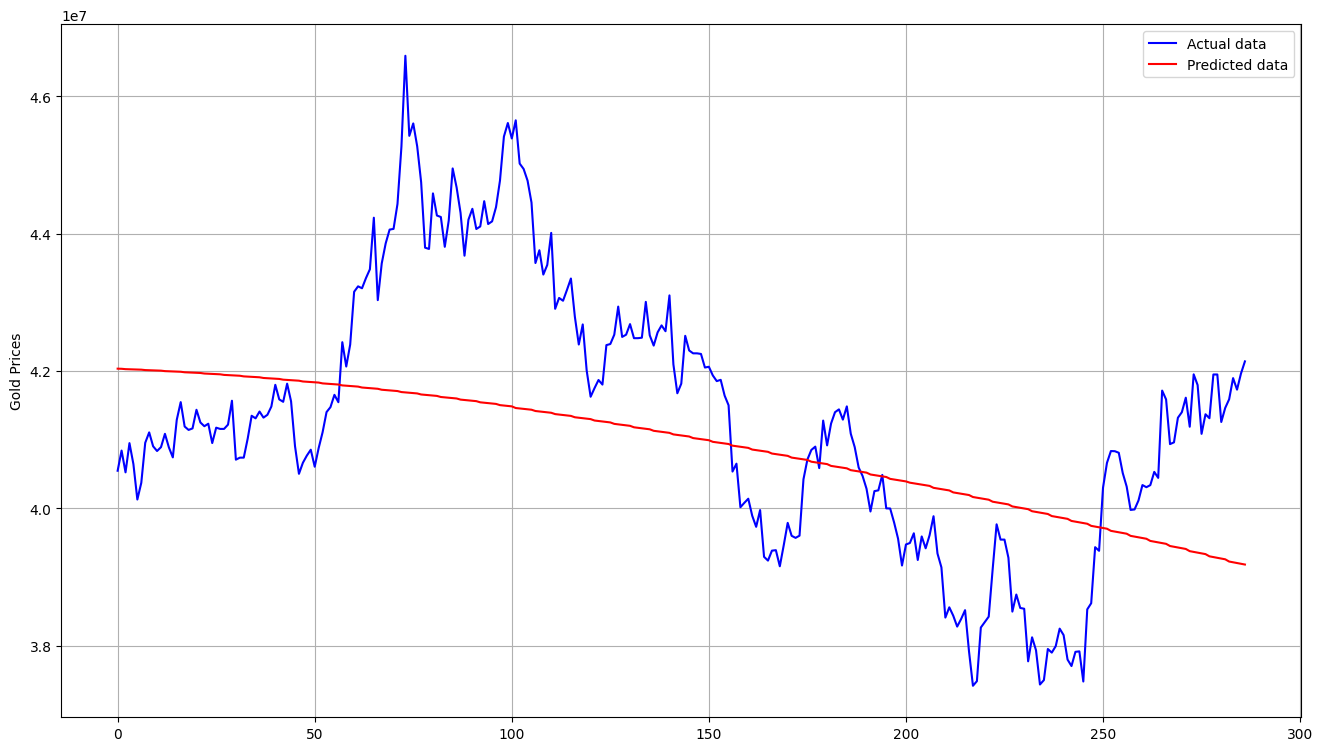

In [17]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Gold Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'red', label='Predicted data')
plt.legend()

#### Model Evaluation

In [18]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred) 
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred) 
rmse = np.sqrt(mse) 
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1428046.38
MAPE: 3.42%
MSE: 2871548085287.00
RMSE: 1694564.28
R2: 0.22


#### Predicting next 30 days price

In [19]:
df1 = pd.read_csv("C:\\Users\\DNV\\OneDrive\\Desktop\\next30days.csv",parse_dates=True,index_col=0)

In [20]:
df1['Timestamp'] = pd.to_datetime(df1.index).astype(np.int64) / 10**9
df_index1 = df1.index
df1

,VND,Timestamp
Date,,
2022-12-31,NaN,1.672445e+09
2023-01-01,NaN,1.672531e+09
2023-01-02,NaN,1.672618e+09
2023-01-03,NaN,1.672704e+09
2023-01-04,NaN,1.672790e+09
2023-01-05,NaN,1.672877e+09
2023-01-06,NaN,1.672963e+09
2023-01-07,NaN,1.673050e+09
2023-01-08,NaN,1.673136e+09


In [21]:
X_sc = StandardScaler()
X = df1.iloc[:, 1].values.reshape(-1, 1)
X_scaled = X_sc.fit_transform(X)
df_scaled_future = pd.DataFrame(index=df_index1)
df_scaled_future['Timestamp'] = X_scaled
df_scaled_future.head()

,Timestamp
Date,
2022-12-31,-1.678744
2023-01-01,-1.570438
2023-01-02,-1.462132
2023-01-03,-1.353826
2023-01-04,-1.245520


In [22]:
X_future = df_scaled_future['Timestamp'].values.reshape(-1, 1)

In [23]:
pred_future = rgs.predict(X_future)

In [24]:
inv_pred_future = y_sc.inverse_transform(pred_future.reshape(-1, 1))

In [26]:
df_pred1 = pd.DataFrame(columns=['Pred'], index=df_index1)
df_pred1['Pred'] = column_or_1d(inv_pred_future)
df_pred1.head()

,Pred
Date,
2022-12-31,3.528811e+07
2023-01-01,3.400807e+07
2023-01-02,3.253673e+07
2023-01-03,3.098496e+07
2023-01-04,2.947988e+07


In [27]:
df_pred1.to_csv(r"C:\\Users\\DNV\\OneDrive\\Desktop\\SVR30d.csv")